In [1]:
%pip install tensorflow scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 4.0 MB/s eta 0:00:000m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 11.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.6 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 10.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 10.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

2025-05-13 21:13:32.504267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 21:13:32.735208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 21:13:32.876861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747181613.043654   50619 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747181613.078550   50619 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747181613.401356   50619 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Constantes
DATA_PATH = 'data/'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
VIEW_POSITION = 'PA' # modelo só para uma posição
TARGET_LABELS = ['0', '1']

In [14]:
print(f"Carregando datasets para posição {VIEW_POSITION}...")

train_dir = os.path.join(DATA_PATH, 'train', VIEW_POSITION)
validation_dir = os.path.join(DATA_PATH, 'validation', VIEW_POSITION)
test_dir = os.path.join(DATA_PATH, 'test', VIEW_POSITION)

Carregando datasets para posição PA...


In [4]:
# checando diretórios
if not os.path.exists(train_dir) or not os.path.exists(validation_dir) or not os.path.exists(test_dir):
    print(f"Error: Diretório para a posiçãos '{VIEW_POSITION}' não encontrados.")
    print(f"Diretórios esperados: {train_dir}, {validation_dir}, {test_dir}")
    print("Por favor verificar se os outros códigos já foram executados.")
    exit()

In [16]:
# Os rótulos são inferidos da estrutura do diretório (0, 1)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary', # para classificação de output sigmoid
    image_size=IMAGE_SIZE,
    interpolation='nearest', # pois as imagens já foram redimensionadas
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    class_names=TARGET_LABELS # passando os nomes para garantir a ordem
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
    class_names=TARGET_LABELS
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
    class_names=TARGET_LABELS
)

Found 10542 files belonging to 2 classes.
Found 1318 files belonging to 2 classes.
Found 1318 files belonging to 2 classes.


In [6]:
# prefetch de data para performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:

# Transfer Learning a partir do MobileNetV2

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE + (3,),
                                               include_top=False, # excluindo camada de classificação
                                               weights='imagenet') # usando pesos pré-treinados no ImageNet

base_model.trainable = False

# criando modelo
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = preprocess_input(inputs)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)


model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

# call backs
checkpoint_filepath = DATA_PATH + 'best_model_pa_effusion.keras' # salvando modelo
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss')

/tmp/ipykernel_50619/2682099134.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE + (3,),


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
print("\nStarting model training...") # iniciando treinamento do modelo
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[early_stopping, model_checkpoint]
)
print("Training finished.")


Starting model training...
Epoch 1/20


2025-05-13 21:13:44.976670: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201326592 exceeds 10% of free system memory.
2025-05-13 21:13:45.070917: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204484608 exceeds 10% of free system memory.


  1/330 ━━━━━━━━━━━━━━━━━━━━ 26:11 5s/step - accuracy: 0.4688 - loss: 1.2366

2025-05-13 21:13:45.791100: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201326592 exceeds 10% of free system memory.
2025-05-13 21:13:45.874728: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204484608 exceeds 10% of free system memory.


  2/330 ━━━━━━━━━━━━━━━━━━━━ 4:01 735ms/step - accuracy: 0.4219 - loss: 1.2453

2025-05-13 21:13:46.507794: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201326592 exceeds 10% of free system memory.


330/330 ━━━━━━━━━━━━━━━━━━━━ 328s 981ms/step - accuracy: 0.6664 - loss: 0.6255 - val_accuracy: 0.7944 - val_loss: 0.4740
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 308s 934ms/step - accuracy: 0.7631 - loss: 0.5099 - val_accuracy: 0.8088 - val_loss: 0.4529
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 281s 851ms/step - accuracy: 0.7785 - loss: 0.4844 - val_accuracy: 0.8058 - val_loss: 0.4465
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 292s 885ms/step - accuracy: 0.7842 - loss: 0.4744 - val_accuracy: 0.8088 - val_loss: 0.4396
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 286s 867ms/step - accuracy: 0.7897 - loss: 0.4631 - val_accuracy: 0.8103 - val_loss: 0.4371
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 322s 977ms/step - accuracy: 0.7956 - loss: 0.4612 - val_accuracy: 0.8141 - val_loss: 0.4372
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 329s 999ms/step - accuracy: 0.7929 - loss: 0.4562 - val_accuracy: 0.8232 - val_loss: 0.4286
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.7950 - loss: 0.4559 

In [13]:
print("\nAvaliando o modelo no conjunto de teste...")
best_model = keras.models.load_model(checkpoint_filepath)

loss, accuracy = best_model.evaluate(test_ds)
print(f"Perda no Teste: {loss:.4f}")
print(f"Acurácia no Teste: {accuracy:.4f}")



Avaliando o modelo no conjunto de teste...
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 898ms/step - accuracy: 0.7994 - loss: 0.4725
Perda no Teste: 0.4472
Acurácia no Teste: 0.8065



Gerando relatório de classificação e matriz de confusão...


2025-05-13 22:23:56.847894: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 884ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.83      0.77      0.80       659
    Classe 1       0.78      0.85      0.81       659

    accuracy                           0.81      1318
   macro avg       0.81      0.81      0.81      1318
weighted avg       0.81      0.81      0.81      1318


Matriz de Confusão:
[[506 153]
 [102 557]]


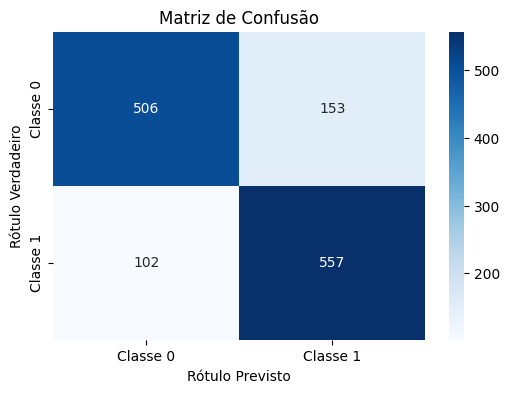


Treinamento e avaliação do modelo concluídos.


In [12]:
print("\nGerando relatório de classificação e matriz de confusão...")

# rotulos verdadeiros e previsões para o conjunto de teste
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_predictions = best_model.predict(test_ds)
test_predictions_binary = (test_predictions > 0.5).astype(int) # convertendo saída sigmoid para binário (0 ou 1)

print("\nRelatório de Classificação:")
print(classification_report(test_labels, test_predictions_binary, target_names=[f'Classe {name}' for name in TARGET_LABELS]))

# matriz de confusão
cm = confusion_matrix(test_labels, test_predictions_binary)
print("\nMatriz de Confusão:")
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Classe {name}' for name in TARGET_LABELS], yticklabels=[f'Classe {name}' for name in TARGET_LABELS])
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

print("\nTreinamento e avaliação do modelo concluídos.")
